<a href="https://colab.research.google.com/github/cleitonmoya/CPS765_Trabalho2/blob/main/CPS765_Trab2_Construcao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Construção e Análise de uma Rede da Covid-19 nos Municípios Brasileiros
*   **Disciplina**: CPS 765 - Redes Complexas
*   **Professor**: Daniel R. Figueiredo
*   **Alunos**: Cleiton Almeida e Girolamo Santoro



In [1]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

## Parte I: Construção da Rede

### 1 Pré-Processamento

Série temporal da Covid-19 nos municípios:

In [2]:
url = 'https://raw.githubusercontent.com/cleitonmoya/CPS765_Trabalho2/main/datasets/casos_idhf_v2.csv'
df = pd.read_csv(url, decimal=',', sep=';', index_col=0, dayfirst=True, parse_dates=True)
df.sort_index(inplace=True)

Municípios:


In [3]:
url = 'https://raw.githubusercontent.com/cleitonmoya/CPS765_Trabalho2/main/datasets/municipios.csv'
df_mun = pd.read_csv(url, sep=';', index_col=0)

Filtrando por casos acumulados até 2020-10-15:

In [4]:
pd.set_option("display.max_columns", 10)
df_ca = df.pivot(columns='city_ibge_code', values='confirmed').loc[:'2020-10-15']

Visualizando os casos acumulados de **São Paulo** e **Rio de Janeiro** e **Belo-Horizonte**:

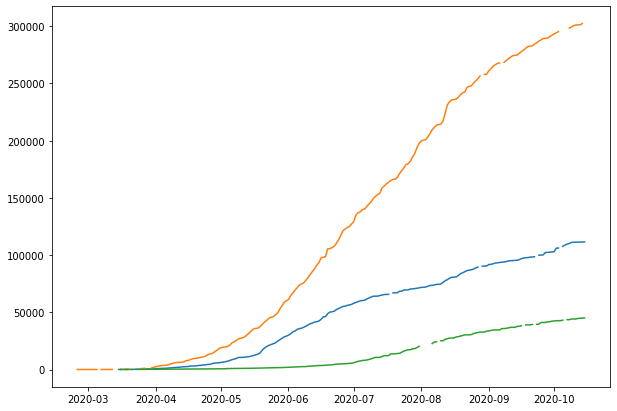

In [5]:
plt.subplots(figsize=(10,7))
plt.plot(df_ca[[3304557, 3550308, 3106200]])
plt.show()

Observamos a presença de descontinuidade nas séries.

#### 1.1 Garantindo que as séries sejam monotônica e sem descontinuidades:

Interpolação para os dias faltantes

In [6]:
df_ca_i = df_ca.interpolate(method='polynomial', order=2)

Substitui os primeiros dias com valores faltantes com 0:

In [7]:
df_ca_i[:'2020-11-01'].fillna(value=0,inplace=True)

Verifica se restou algum dia com valores faltantes:

In [8]:
df_temp = pd.DataFrame(df_ca_i.isna().sum())
df_temp[df_temp!=0].dropna()

,0
city_ibge_code,


Garantindo a monotonicidade crescente a fim de não haver casos negativos:

In [9]:
cidades = df_ca_i.columns.tolist()
for c in cidades:
  s = df_ca_i[c]
  if not s.is_monotonic:
    for i,v in enumerate(s):
      if i>0:
        if v<s[i-1]:
          s[i] = s[i-1]
        df_ca_i[c] = s

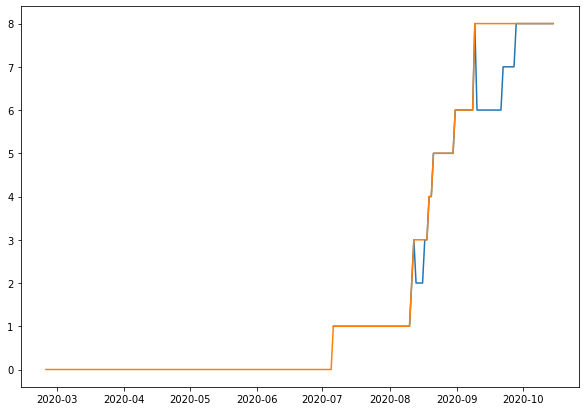

In [10]:
plt.subplots(figsize=(10,7))
plt.plot(df_ca[[5221577]])
plt.plot(df_ca_i[[5221577]])
plt.show()

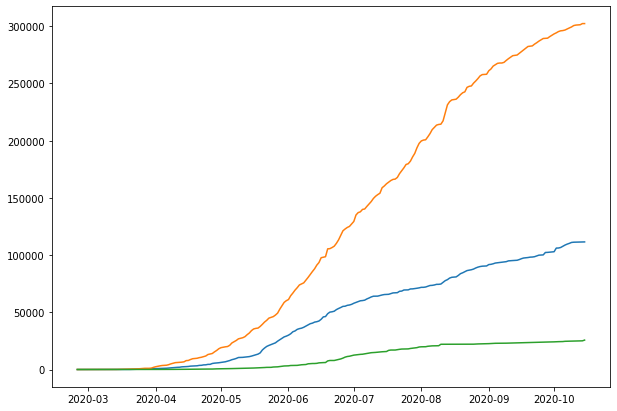

In [11]:
plt.subplots(figsize=(10,7))
plt.plot(df_ca_i[[3304557, 3550308, 2408102]])
plt.show()

#### 1.2 Casos novos diários

In [12]:
df_cn = df_ca_i.diff(periods=1)[1:]

Média móvel de 7 dias:

In [13]:
df_casos_mm = df_cn.rolling(7).mean().dropna()

[]

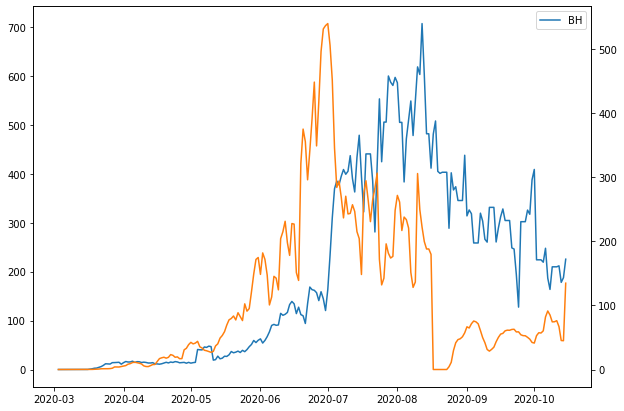

In [14]:
# BH x Natal
fig,ax1 = plt.subplots(figsize=(10,7))
ax1.plot(df_cn[3106200].rolling(7).mean(), label='BH')
ax2 = ax1.twinx()
ax2.plot(df_cn[2408102].rolling(7).mean(), c='C1', label='Natal')
ax1.legend()
plt.plot()

### 2 Construção da Rede

#### 2.1 Matriz de correlação

In [15]:
M_Cor = df_casos_mm.corr()

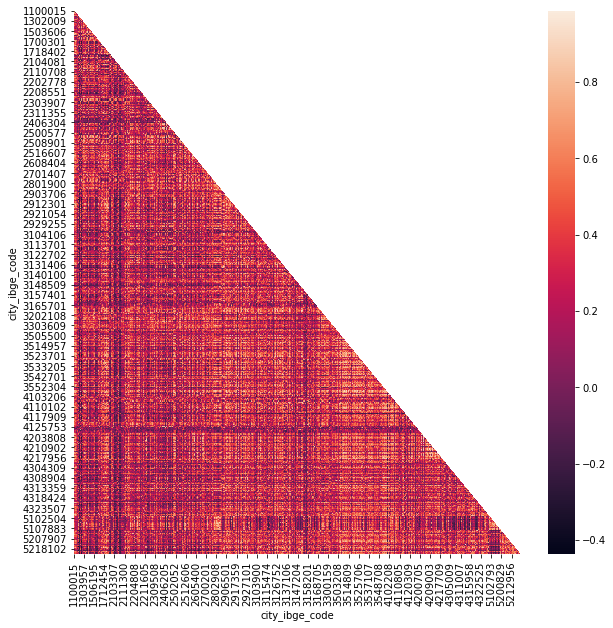

In [35]:
fig, axs = plt.subplots(figsize=(10,10))
mask = np.triu(np.ones_like(M_Cor, dtype=bool)) # Generate a mask for the upper triangle
ax = sns.heatmap(M_Cor,mask=mask)

Limiar para a definição das arestas da rede:

In [17]:
T = 0.90

In [18]:
M_Cor.describe()

city_ibge_code,1100015,1100023,1100031,1100049,1100056,...,5222005,5222054,5222203,5222302,5300108
count,5565.000000,5565.000000,5565.000000,5565.000000,5565.000000,...,5565.000000,5565.000000,5565.000000,5565.000000,5565.000000
mean,0.456639,0.476554,0.383467,0.453747,0.456120,...,0.361698,0.337698,0.320212,0.424797,0.501660
std,0.235781,0.226991,0.216375,0.251942,0.237380,...,0.175251,0.228680,0.225650,0.279427,0.220362
min,-0.346932,-0.281620,-0.340778,-0.299517,-0.291929,...,-0.289266,-0.309010,-0.268808,-0.403917,-0.323141
25%,0.305017,0.312741,0.258071,0.280000,0.293188,...,0.246752,0.182414,0.144615,0.248484,0.353434
50%,0.485527,0.498477,0.420262,0.483758,0.490080,...,0.376213,0.367310,0.318481,0.471327,0.524829
75%,0.637780,0.655156,0.539457,0.655006,0.644484,...,0.490481,0.517442,0.493001,0.641329,0.668005
max,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
(M_Cor >= T).sum().sort_values()

city_ibge_code
3108503     0
3149408     0
3110400     0
3165206     0
3146305     1
           ..
4317202    78
3556701    80
3501608    82
3549805    88
2903201    90
Length: 5569, dtype: int64

In [20]:
(M_Cor >= T).sum().describe()

count    5569.000000
mean        3.663674
std         7.784234
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        90.000000
dtype: float64

In [21]:
M_Cor[3106200].sort_values()[-10:]

city_ibge_code
3543402    0.935115
3556701    0.935479
4106902    0.942890
3549805    0.944483
4100400    0.948452
3106200    1.000000
3108503         NaN
3110400         NaN
3149408         NaN
3165206         NaN
Name: 3106200, dtype: float64

Exemplo: BH x Almirante do Tamandaré (PR)

In [22]:
M_Cor[3106200][4100400]

0.9484524332552371

[]

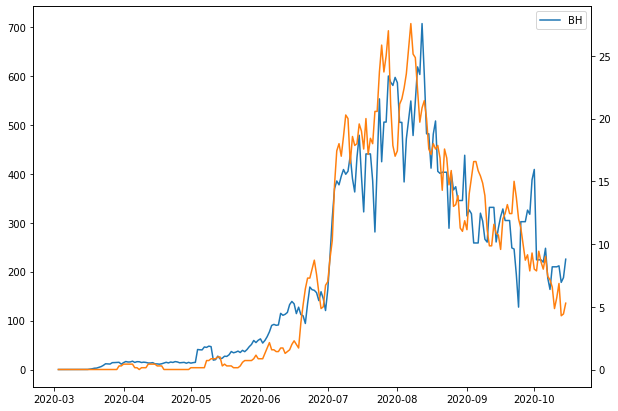

In [23]:
# BH x Almirante do Itamandaré (PR)
fig,ax1 = plt.subplots(figsize=(10,7))
ax1.plot(df_cn[3106200].rolling(7).mean(), label='BH')
ax2 = ax1.twinx()
ax2.plot(df_cn[4100400].rolling(7).mean(), c='C1')
ax1.legend()
plt.plot()

#### 2.2 Distribuição de grau preliminar

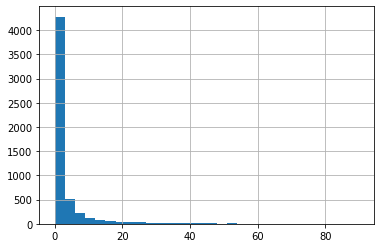

In [24]:
(M_Cor >= T).sum().hist(bins=30)
plt.show()

Observamos uma distribuição de grau aparentemente com cauda pesada.

#### 2.3 Geração da rede

In [25]:
df_A = (M_Cor>T).astype(int)      # Matriz de adjancências
np.fill_diagonal(df_A.values, 0)  # com diagonal 0

In [26]:
G = nx.from_pandas_adjacency(df_A)

Inclusão dos atributos:

In [27]:
dic_municipios = df_mun.to_dict('index')

In [28]:
nx.set_node_attributes(G, dic_municipios)

Visualização da rede:

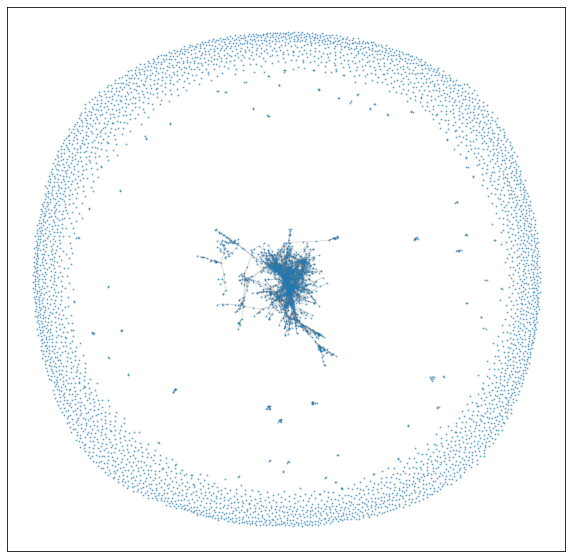

In [29]:
random.seed(15)
np.random.seed(15)
plt.figure(figsize=(10,10))
nx.draw_networkx(G, node_size=1, edge_color='grey', alpha=0.5, width=0.5, with_labels=False)
plt.show()

Componentes conexas:

In [30]:
tam_cc = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
print("Número de componentes conexas:", nx.number_connected_components(G)) 
print("Tamanho das componentes conexas:", tam_cc)

Número de componentes conexas: 3881
Tamanho das componentes conexas: [1507, 30, 10, 9, 8, 7, 7, 6, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

Maior componente conexa:

In [31]:
maior_cc = max(nx.connected_components(G), key=len)
S = G.subgraph(maior_cc).copy()

Salva a rede no formato GraphML

In [32]:
nx.write_graphml_lxml(S,"S.graphml")
nx.write_graphml_lxml(G,"G.graphml")

Visualização da componente conexa gigante:

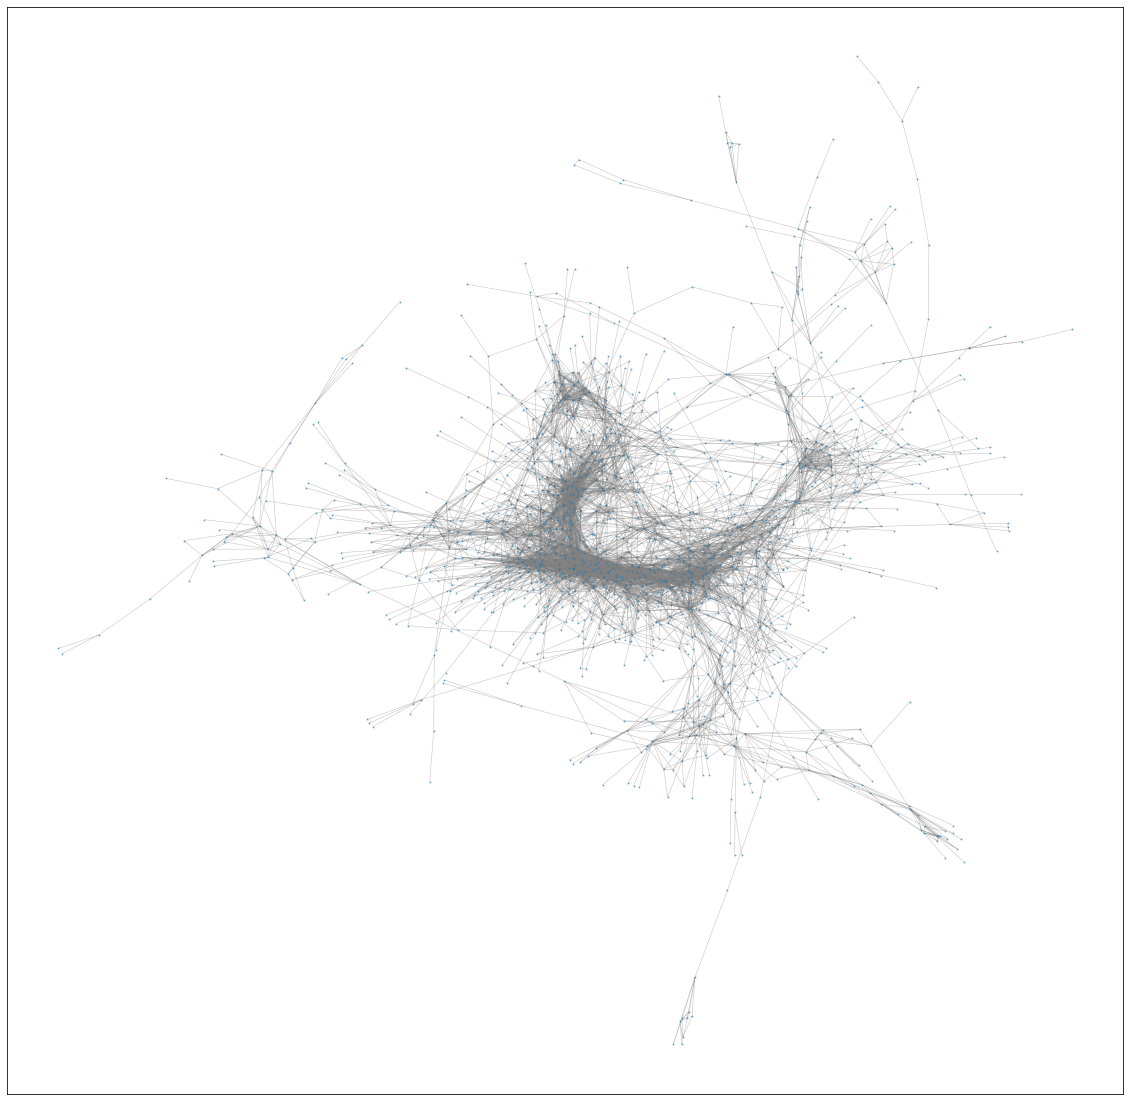

In [33]:
random.seed(10)
np.random.seed(10)
plt.figure(figsize=(20,20))
nx.draw_networkx(S, node_size=1, edge_color='grey', alpha=0.5, width=0.5, with_labels=False)
plt.show()

Distância média da rede:

In [34]:
d_mean = nx.average_shortest_path_length(S)
print('Distância média:',d_mean)

Distância média: 6.430325589920786
